# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python
from unityagents import UnityEnvironment
import numpy as np
import torch
from collections import deque
import matplotlib.pyplot as plt

# Create the Agent
from td3_model import Agent

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.9 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


### 4. Model selected: DDPG - TD3

Based on: https://spinningup.openai.com/en/latest/algorithms/td3.html

Deep Deterministic Policy Gradient (DDPG) is an algorithm which concurrently learns a Q-function and a policy. It uses off-policy data and the Bellman equation to learn the Q-function, and uses the Q-function to learn the policy.

While DDPG can achieve great performance sometimes, it is frequently brittle with respect to hyperparameters and other kinds of tuning. A common failure mode for DDPG is that the learned Q-function begins to dramatically overestimate Q-values, which then leads to the policy breaking, because it exploits the errors in the Q-function. Twin Delayed DDPG (TD3) is an algorithm which addresses this issue by introducing three critical tricks:

**Trick One:** Clipped Double-Q Learning. TD3 learns two Q-functions instead of one (hence “twin”), and uses the smaller of the two Q-values to form the targets in the Bellman error loss functions.

**Trick Two:** “Delayed” Policy Updates. TD3 updates the policy (and target networks) less frequently than the Q-function. The paper recommends one policy update for every two Q-function updates.

**Trick Three:** Target Policy Smoothing. TD3 adds noise to the target action, to make it harder for the policy to exploit Q-function errors by smoothing out Q along changes in action.

![Model](https://spinningup.openai.com/en/latest/_images/math/52d3d2df4225f9fec06156d6e1d3da26c8b27bc5.svg)

### 5. Training Agents

#### Hyperparameters
BUFFER_SIZE = int(1e6)  # replay buffer size  
BATCH_SIZE = 256        # minibatch size  
GAMMA = 0.995           # discount factor  
TAU = 1e-3              # for soft update of target parameters  
LR_ACTOR = 0.1e-3       # learning rate of the actor   
LR_CRITIC = 1e-3        # learning rate of the critic  
WEIGHT_DECAY = 1e-6     # L2 weight decay  

In [6]:
agents =[]

for i in range(num_agents):
    agents.append(Agent(state_size, action_size, 
        random_seed = 1, agent_size=1, max_action = 1))

In [7]:
def ddpg_td3(n_episodes=150, max_t=500, consecutive_episodes = 100, 
             learn_every = 10, n_experiences = 20, target_avg_score = 0.5, noise = 2.0, noise_grad = 0.999,
             num_agents = 2, print_every=5):
    """Deep Deterministic Policy Gradients DDPG  from Pendulum exercise was employed: 
       Params:
            n_episodes (int): maximum number of training episodes
            max_t (int): maximum number of timesteps per episode
            consecutive_episodes (int): number of consecutive episodes
            learn_every (int): update the network every n timesteps
            n_experiences (int): update the netword n times
            target_avg_score (int): target avg score of the range of n consecutive_episodes
            noise = (float): noise added to actions
            noise_grad = noise adjestment per episode
            num_agents = number of agents
            print_every (int): print the training every n timesteps
    """
    total_scores = [] 
    scores_windows = deque(maxlen=consecutive_episodes)
    scores = [] # list containing scores 
    save = True
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        agents_scores = np.zeros(num_agents)
        noise_level= noise
        noise_gradient = noise_grad
        
        for t in range(max_t):
            actions = []
            for i in range(len(states)):
                actions.append(agents[i].act(states[i], noise_reduction= noise_level))
            noise_level*=noise_grad
            noise_level = max(noise_level, 0)
            env_info = env.step(actions)[brain_name]           # send all actions to the environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done
            
            for i in range(num_agents):
                agents[i].step(states[i], actions[i], rewards[i], next_states[i], dones[i],
                               t, learn_every, n_experiences)

            states = next_states
            agents_scores += rewards

        scores_windows.append(np.max(agents_scores))
        total_scores.append(agents_scores)
        average_score = np.mean(scores_windows)
        

        if i_episode % print_every == 0:
            print('\n\rEpisode {}\tAverage Score: {:.4f}\tScore: {:.4f}\n'.format(i_episode, 
                                                                              average_score, np.max(agents_scores)))
 
        if average_score >=target_avg_score:
            if save:
                print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.5f}'.format(i_episode, average_score))
                for i in range(num_agents):
                    torch.save(agents[i].actor_local.state_dict(),  'td3_actor{}.pth'.format(i))
                    torch.save(agents[i].critic_local.state_dict(), 'td3_critic{}.pth'.format(i))
                save = False   
    return total_scores


    
scores = ddpg_td3()

    


Episode 5	Average Score: -0.0420	Score: -0.0700


Episode 10	Average Score: -0.0700	Score: 0.0300


Episode 15	Average Score: -0.0980	Score: -0.1500


Episode 20	Average Score: -0.0635	Score: 0.0000


Episode 25	Average Score: -0.0068	Score: 0.7500


Episode 30	Average Score: 0.1620	Score: 1.0600


Episode 35	Average Score: 0.2614	Score: 0.9100


Episode 40	Average Score: 0.3660	Score: 0.9700


Episode 45	Average Score: 0.4644	Score: 1.0800


Environment solved in 47 episodes!	Average Score: 0.50000

Episode 50	Average Score: 0.5412	Score: 1.0800


Episode 55	Average Score: 0.6078	Score: 1.1900


Episode 60	Average Score: 0.6635	Score: 1.2000


Episode 65	Average Score: 0.7015	Score: 1.0600


Episode 70	Average Score: 0.7456	Score: 1.3000


Episode 75	Average Score: 0.7808	Score: 1.2900


Episode 80	Average Score: 0.8115	Score: 1.3000


Episode 85	Average Score: 0.8389	Score: 1.2900


Episode 90	Average Score: 0.8631	Score: 1.3000


Episode 95	Average Score: 0.8803	Score: 1.0900


Epi

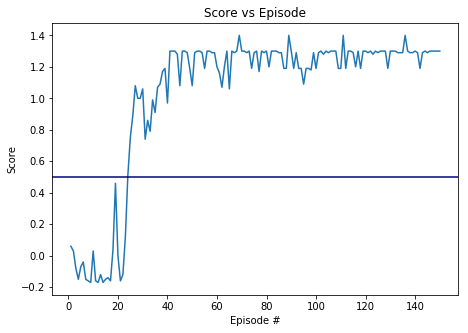

In [33]:
target_avg_score = 0.5

fig = plt.figure(figsize=(16,5))
ax = fig.add_subplot(121)
plt.plot(np.arange(1, len(scores)+1), np.max(scores,axis=1))
plt.axhline(y=target_avg_score, color='navy', linestyle='-')
plt.title('Score vs Episode')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [19]:
env.close()

### 6. Future ideas

I'd like to understand the implementation of the paper: **On-Policy Trust Region Policy Optimisation with Replay Buffers**, Dmitry Kangin, Nicolas Pugeault.

https://arxiv.org/abs/1901.06212
    
**Summary:**
    
Building upon the recent success of deep reinforcement learning methods, we investigate the possibility of on-policy reinforcement learning improvement by reusing the data from several consecutive policies. On-policy methods bring many benefits, such as ability to evaluate each resulting policy. However, they usually discard all the information about the policies which existed before. In this work, we propose adaptation of the replay buffer concept, borrowed from the off-policy learning setting, to create the method, combining advantages of on- and off-policy learning. To achieve this, the proposed algorithm generalises the Q-, value and advantage functions for data from multiple policies. The method uses trust region optimisation, while avoiding some of the common problems of the algorithms such as TRPO or ACKTR: it uses hyperparameters to replace the trust region selection heuristics, as well as the trainable covariance matrix instead of the fixed one. In many cases, the method not only improves the results comparing to the state-of-the-art trust region on-policy learning algorithms such as PPO, ACKTR and TRPO, but also with respect to their off-policy counterpart DDPG.    